In [1]:
# Import libraries. 
# Generate images in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import gzip
import itertools
import numpy as np
import os
import time
import pandas as pd
import seaborn as sns

import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file

# Import colour palettes for later on
from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy

# Dimension reduction tools
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE
import umap 

In [2]:
#loading population data
population_names= pd.read_excel(r'popmap_sorted.xls')
print(population_names)


      CLUSTER      IID
0    MApop015  PA_1001
1    MApop015  PA_1004
2    MApop015  PA_1005
3    MApop015  PA_1008
4    MApop015  PA_1011
..        ...      ...
397  MApop015   PA_993
398  MApop015   PA_995
399   Unknown    PA_x1
400   Unknown    PA_x2
401   Unknown    PA_x3

[402 rows x 2 columns]


In [3]:
#Generating the pandas dataframe called Data_Struct
Data_Struct=population_names

In [4]:
#loading the covariance matrix

#data: 
#cov_mat= pd.read_excel(r'pa_r10_mf01_ld_para_mmq30_maf05.xls')

cov_mat_deneme=pd.read_csv('pa_r10_mf01_ld_para_mmq30_maf01.txt',sep='\t', header=None)


cov_mat_np=cov_mat_deneme.to_numpy()

print(cov_mat_deneme.shape)
print(cov_mat_np.shape)
#print(cov_mat_deneme.head(1))


#sns.heatmap(cov_mat_np)
#print(cov_mat_np)

(402, 402)
(402, 402)


In [5]:
# calculating eigen vectors and eigen values from the initial covariance matrix
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat_np)

# sorting them from largest to smallest

idx = eigen_vals.argsort()[::-1]   
eigenValues = eigen_vals[idx]
eigenVectors = eigen_vecs[:,idx]


eigvec_mltply_val=eigenVectors.real*eigenValues.real # this is the weighted PCA

#checking the dimensions
#print(eigenVectors.shape)
#print(eigvec_mltply_val.shape)

In [6]:
# calculating the total explained variance
#expl=np.cumsum(eigenvals)/sum(eigenvals)

expl_pre=eigenValues/sum(eigenValues)
expl=np.cumsum(expl_pre)

expl_df=pd.DataFrame(expl_pre*100,columns=['explained_variance'])
expl_df['cumulative_expl']=expl*100
expl_df.set_index(np.arange(1,403))

,explained_variance,cumulative_expl
1,5.135131,5.135131
2,4.712933,9.848064
3,4.427698,14.275762
4,3.753293,18.029054
5,3.110085,21.139140
...,...,...
398,0.049694,99.850110
399,0.046787,99.896897
400,0.042224,99.939122
401,0.031895,99.971016


In [19]:
print(expl_df.head(25))

    explained_variance  cumulative_expl
0             5.135131         5.135131
1             4.712933         9.848064
2             4.427698        14.275762
3             3.753293        18.029054
4             3.110085        21.139140
5             2.278536        23.417676
6             2.050306        25.467983
7             1.859444        27.327426
8             1.741444        29.068870
9             1.428579        30.497449
10            1.237108        31.734558
11            1.071235        32.805793
12            1.018730        33.824523
13            0.952521        34.777043
14            0.892285        35.669329
15            0.637067        36.306396
16            0.602644        36.909039
17            0.561946        37.470985
18            0.546081        38.017067
19            0.532512        38.549578
20            0.502539        39.052118
21            0.485376        39.537493
22            0.480059        40.017553
23            0.472560        40.490112


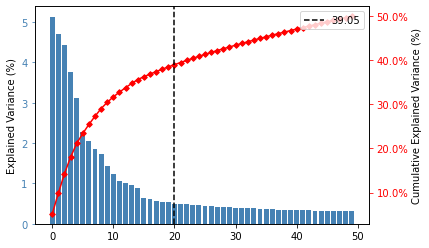

In [8]:
#plotting the total explained variance
from matplotlib.ticker import PercentFormatter

trial_npc=20

#plt.plot(np.arange(1,50+1),expl[:50]*100)


#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(expl_df.index[0:50], expl_df['explained_variance'][0:50], color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(expl_df.index[0:50], expl_df['cumulative_expl'][0:50], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)


#add labels and title

plt.xlabel("# of PCs")
ax.set_ylabel("Explained Variance (%)")
ax2.set_ylabel("Cumulative Explained Variance (%)")

plt.axvline(x = trial_npc, color = 'k',linestyle = '--',label = str(round(expl_df.cumulative_expl[trial_npc],2)))
plt.legend(loc ='upper right')

#display Pareto chart
#plt.savefig('PCA_paretoplot_maf01.png',dpi=100,transparent = False,facecolor='white')
plt.show()




In [27]:
Data_Struct['EigenVect1']=eigenVectors.real[:,0]
Data_Struct['EigenVect2']=eigenVectors.real[:,1]
Data_Struct['wEigenVect1']=eigvec_mltply_val.real[:,0]
Data_Struct['wEigenVect2']=eigvec_mltply_val.real[:,1]
Data_Struct['wEigenVect3']=eigvec_mltply_val.real[:,2]


print(Data_Struct.head(5))




    CLUSTER      IID  EigenVect1  EigenVect2  wEigenVect1  wEigenVect2  \
0  MApop015  PA_1001   -0.024848    0.005647    -0.652647     0.136140   
1  MApop015  PA_1004   -0.022246    0.004293    -0.584306     0.103482   
2  MApop015  PA_1005   -0.021980    0.008059    -0.577321     0.194278   
3  MApop015  PA_1008   -0.027616    0.008804    -0.725360     0.212223   
4  MApop015  PA_1011   -0.024599    0.007680    -0.646101     0.185131   

       tSNE1     tSNE2  tSNE1_multip  tSNE2_multip     UMAP1     UMAP2  \
0  15.964427 -5.387426     -9.552842     16.024286 -2.250366 -0.150036   
1  15.747587 -5.323174     -9.614470     15.681901 -2.254964 -0.303965   
2  16.179058 -5.339168     -9.473195     16.102297 -2.192827 -0.059706   
3  16.157536 -5.281817     -9.625036     16.595947 -2.375278 -0.137686   
4  16.736553 -4.251500     -9.193893     16.451180 -2.832665 -0.943725   

   UMAP1_multip  UMAP2_multip  wEigenVect3  
0    -10.479782    -12.995019     0.277816  
1    -10.148773    -

In [20]:
# Number of principal components to use
n_pc = 25


In [21]:
eigen_vecs_real=eigenVectors.real # remeving the imaginary part of the eigen vectors
n_neighbors_num=15
mindist=0.5
# Project the eigenvectors via t-SNE to 2 dimensions.
np.random.seed(111)
proj_tsne_eig = TSNE(n_components=2).fit_transform(eigen_vecs_real[:,:n_pc])

# Project the eigenvectors via UMAPto 2 dimensions.
np.random.seed(111)
proj_umap_eig = umap.UMAP(n_components=2, n_neighbors=n_neighbors_num, min_dist=mindist).fit_transform(eigen_vecs_real[:,:n_pc])

# Project the eigenvectors*eigenvalues via t-SNE to 2 dimensions.
np.random.seed(111)
proj_tsne_eigvecval = TSNE(n_components=2).fit_transform(eigvec_mltply_val[:,:n_pc])

# Project the eigenvectors via UMAPto 2 dimensions.
np.random.seed(111)
proj_umap_eigvecval = umap.UMAP(n_components=2, n_neighbors=n_neighbors_num, min_dist=mindist).fit_transform(eigvec_mltply_val[:,:n_pc])

In [22]:
Data_Struct['tSNE1']=proj_tsne_eig[:,0]
Data_Struct['tSNE2']=proj_tsne_eig[:,1]

Data_Struct['tSNE1_multip']=proj_tsne_eigvecval[:,0]
Data_Struct['tSNE2_multip']=proj_tsne_eigvecval[:,1]

Data_Struct['UMAP1']=proj_umap_eig[:,0]
Data_Struct['UMAP2']=proj_umap_eig[:,1]

Data_Struct['UMAP1_multip']=proj_umap_eigvecval[:,0]
Data_Struct['UMAP2_multip']=proj_umap_eigvecval[:,1]

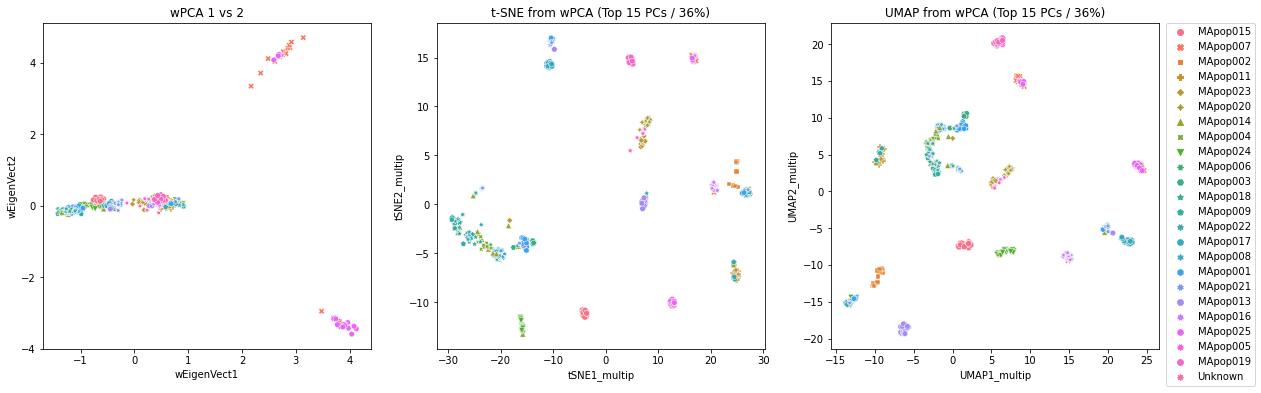

In [18]:
fig, axs = plt.subplots(1, 3,figsize=(20, 6))

#axs[1,1] = Data_Struct.plot.scatter(x='X1',y='X2',c='Population')
sns.scatterplot(ax=axs[0],data=Data_Struct, x='wEigenVect1', y='wEigenVect2', hue='CLUSTER', style='CLUSTER',legend = False).set(title='wPCA 1 vs 2')
sns.scatterplot(ax=axs[1],data=Data_Struct, x='tSNE1_multip', y='tSNE2_multip', hue='CLUSTER',style='CLUSTER',legend = False).set(title='t-SNE from wPCA (Top 15 PCs / 36%)')
sns.scatterplot(ax=axs[2],data=Data_Struct, x='UMAP1_multip', y='UMAP2_multip', hue='CLUSTER',style='CLUSTER').set(title='UMAP from wPCA (Top 15 PCs / 36%)')
#for i in range(1,143):
#    plt.text(x=Data_Struct['UMAP1_multip'][i]+0.05, y=Data_Struct['UMAP2_multip'][i],s=Data_Struct['Sample'][i])
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('wPCA_tSNE_UMAP_top15PCs_maf01_newcursors.png',dpi=100,transparent = False,facecolor='white')
plt.savefig('wPCA_tSNE_UMAP_top15PCs_maf01_newcursors.pdf',dpi=200,transparent = False,facecolor='white')




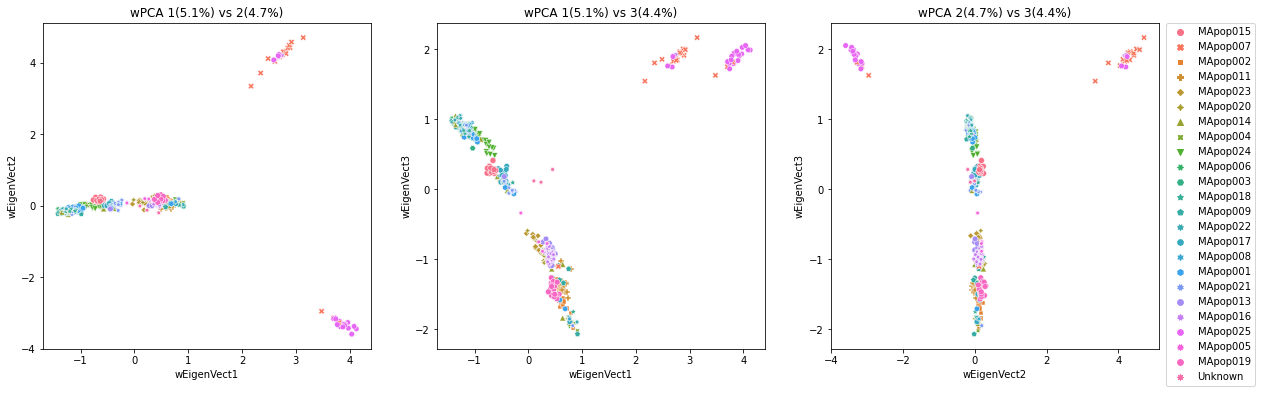

In [29]:
fig, axs = plt.subplots(1, 3,figsize=(20, 6))

#axs[1,1] = Data_Struct.plot.scatter(x='X1',y='X2',c='Population')
sns.scatterplot(ax=axs[0],data=Data_Struct, x='wEigenVect1', y='wEigenVect2', hue='CLUSTER', style='CLUSTER',legend = False).set(title='wPCA 1(5.1%) vs 2(4.7%)')
sns.scatterplot(ax=axs[1],data=Data_Struct, x='wEigenVect1', y='wEigenVect3', hue='CLUSTER',style='CLUSTER',legend = False).set(title='wPCA 1(5.1%) vs 3(4.4%)')
sns.scatterplot(ax=axs[2],data=Data_Struct, x='wEigenVect2', y='wEigenVect3', hue='CLUSTER',style='CLUSTER').set(title='wPCA 2(4.7%) vs 3(4.4%)')
#for i in range(1,143):
#    plt.text(x=Data_Struct['UMAP1_multip'][i]+0.05, y=Data_Struct['UMAP2_multip'][i],s=Data_Struct['Sample'][i])
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('wPCA_maf01_1vs3_2vs3.pdf',dpi=200,transparent = False,facecolor='white')



In [ ]:
#single plot with text
fig, axs = plt.subplots(1, 1,figsize=(12, 12))

sns.scatterplot(ax=axs,data=Data_Struct, x='tSNE1_multip', y='tSNE2_multip', hue='CLUSTER').set(title='t-SNE from wPCA (Top 15 PCs / 22.5%)')

for i in range(1,402):
    plt.text(x=Data_Struct['tSNE1_multip'][i]+0.05, y=Data_Struct['tSNE2_multip'][i],s=Data_Struct['IID'][i])
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#plt.savefig('tSNE_with_Samplenametexts_v2.png',dpi=100,transparent = False,facecolor='white')

